In [77]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [78]:
import numpy as np
import pandas as pd

In [79]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [80]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import extract

In [81]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [82]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [83]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [84]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [85]:
# Create our session (link) from Python to the DB
session = Session(engine)

In [86]:
#MAX DATE
max_date = session.query(func.max( Measurement.date)).limit(5).all()
max_date[0][0]


'2017-08-23'

# Exploratory Climate Analysis

In [87]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
# Calculate the date 1 year ago from the last data point in the database
# Perform a query to retrieve the data and precipitation score
precipitation_data = session.query(func.strftime("%Y-%m-%d", Measurement.date), Measurement.prcp).\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()


# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_data_df= pd.DataFrame(precipitation_data, columns=('date','precipitation'))
# Sort the dataframe by date
precipitation_data_df.set_index('date', inplace=True)
precipitation_data_df.sort_values(by='date')
precipitation_data_df.head(100)
# Use Pandas Plotting with Matplotlib to plot the data


,precipitation
date,
2016-08-23,0.00
2016-08-24,0.08
2016-08-25,0.08
2016-08-26,0.00
2016-08-27,0.00
...,...
2016-11-26,0.05
2016-11-27,0.00
2016-11-28,0.01


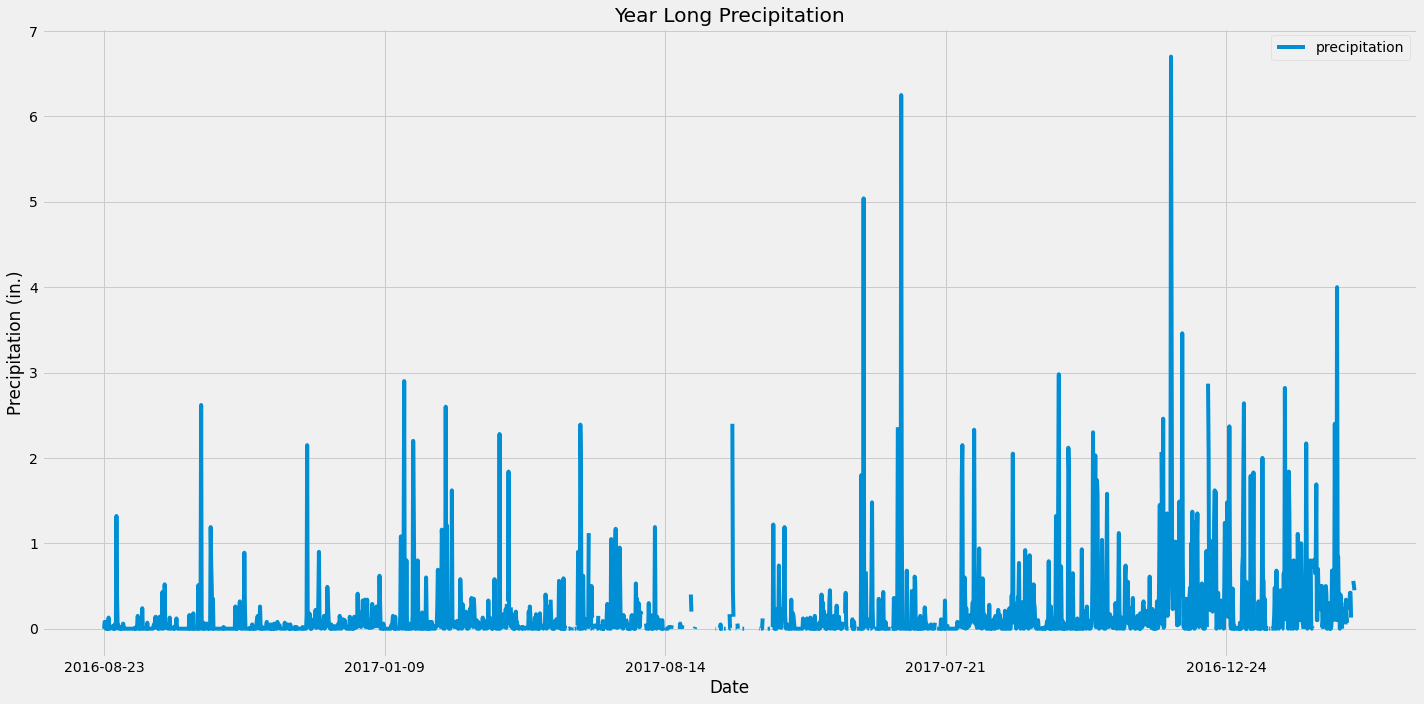

In [88]:
fig, ax = plt.subplots(figsize = (20, 10))
precipitation_data_df.plot(ax = ax, x_compat = True)

#title and labels
ax.set_xlabel('Date')
ax.set_ylabel('Precipitation (in.)')
ax.set_title("Year Long Precipitation")

plt.savefig("Images/precipitation.png")

#plot
plt.tight_layout()
plt.show()

In [89]:
# Use Pandas to calcualte the summary statistics for the precipitation data

In [90]:
precipitation_data_df.describe()

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [91]:
# Design a query to show how many stations are available in this dataset?
station_number= session.query(func.count( Station.station)).all()
station_number


[(9)]

In [92]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_station=session.query(Measurement.station, func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_station

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [93]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
most_active_station1=session.query(func.max(Measurement.tobs),func.min(Measurement.tobs),func.avg(Measurement.tobs)).filter_by(station='USC00519281').all()
most_active_station1

[(85.0, 54.0, 71.66378066378067)]

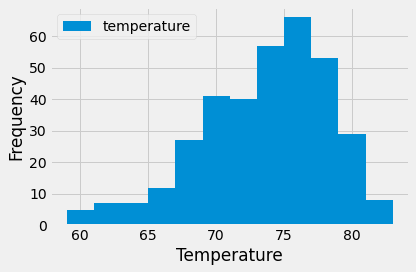

In [94]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_observation = session.query(Measurement.date, Measurement.tobs).filter_by(station ='USC00519281').\
    filter(func.strftime("%Y-%m-%d", Measurement.date) >= dt.date(2016, 8, 23)).all()

#save as a data frame
temp_observation_df = pd.DataFrame(temp_observation, columns = ['date', 'temperature'])

fig, ax = plt.subplots()
temp_observation_df.plot.hist(bins = 12, ax = ax)

#labels
ax.set_xlabel('Temperature')
ax.set_ylabel('Frequency')

#save figure
plt.savefig("Images/yearly_plot.png")

#plot
plt.tight_layout()
plt.show()

## Bonus Challenge Assignment

In [95]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2017-01-01', '2017-01-07'))

[(62.0, 68.36585365853658, 74.0)]


In [96]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
import datetime as dt

prev_year_start = dt.date(2016, 1, 1) - dt.timedelta(days=365)
prev_year_end = dt.date(2017, 1, 1) - dt.timedelta(days=365)

tmin, tavg, tmax = calc_temps(prev_year_start.strftime("%Y-%m-%d"), prev_year_end.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

56.0 73.84128289473684 86.0


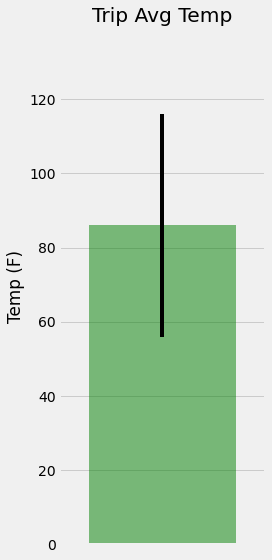

In [97]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
fig, ax = plt.subplots(figsize=plt.figaspect(2.))
xpos = 1
yerr = tmax-tmin

bar = ax.bar(xpos, tmax, yerr=yerr, alpha=0.5, color='green', align="center")
ax.set(xticks=range(xpos), xticklabels="a", title="Trip Avg Temp", ylabel="Temp (F)")
ax.margins(.2, .2)
# fig.autofmt_xdate()
fig.tight_layout()
fig.show()


In [98]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

start_date = '2017-01-01'
end_date = '2017-01-07'

sel = [Station.station, Station.name, Station.latitude, 
       Station.longitude, Station.elevation, func.sum(Measurement.prcp)]

results = session.query(*sel).\
    filter(Measurement.station == Station.station).\
    filter(Measurement.date >= start_date).\
    filter(Measurement.date <= end_date).\
    group_by(Station.name).order_by(func.sum(Measurement.prcp).desc()).all()
print(results)

[('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.61), ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.6), ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.6), ('USC00513117', 'KANEOHE 838.1, HI US', 21.4234, -157.8015, 14.6, 0.35), ('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.2), ('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.0)]


In [99]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [100]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`
trip_start = '2017-01-01'
trip_end = '2017-01-07'
# Set the start and end date of the trip
trip_dates = pd.date_range(trip_start, trip_end, freq='D')
# Use the start and end date to create a range of dates
trip_month_day = trip_dates.strftime('%m-%d')
# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date
normals = []
for date in trip_month_day:
    normals.append(*daily_normals(date))
    
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [101]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
df = pd.DataFrame(normals, columns=['tmin', 'tavg', 'tmax'])
df['date'] = trip_dates
df.set_index(['date'],inplace=True)
df.head()

,tmin,tavg,tmax
date,,,
2017-01-01,62.0,69.153846,77.0
2017-01-02,60.0,69.396226,77.0
2017-01-03,62.0,68.909091,77.0
2017-01-04,58.0,70.000000,76.0
2017-01-05,56.0,67.964286,76.0


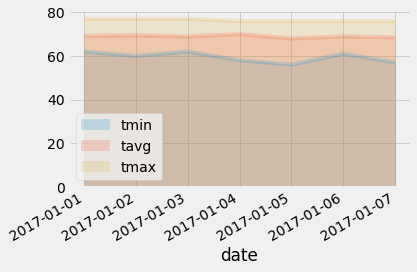

In [102]:
# Plot the daily normals as an area plot with `stacked=False`
df.plot(kind='area', stacked=False, x_compat=True, alpha=.2)
plt.tight_layout()

In [103]:

jun_month=session.query(Measurement.date,Measurement.tobs).\
    filter(extract('month',Measurement.date ) == 6).all()
jun_month

[('2010-06-01', 78.0),
 ('2010-06-02', 76.0),
 ('2010-06-03', 78.0),
 ('2010-06-04', 76.0),
 ('2010-06-05', 77.0),
 ('2010-06-06', 78.0),
 ('2010-06-07', 77.0),
 ('2010-06-08', 78.0),
 ('2010-06-09', 78.0),
 ('2010-06-10', 79.0),
 ('2010-06-11', 78.0),
 ('2010-06-12', 78.0),
 ('2010-06-13', 78.0),
 ('2010-06-14', 77.0),
 ('2010-06-15', 78.0),
 ('2010-06-16', 78.0),
 ('2010-06-17', 77.0),
 ('2010-06-18', 77.0),
 ('2010-06-19', 82.0),
 ('2010-06-20', 78.0),
 ('2010-06-21', 78.0),
 ('2010-06-22', 78.0),
 ('2010-06-23', 78.0),
 ('2010-06-24', 78.0),
 ('2010-06-25', 77.0),
 ('2010-06-26', 76.0),
 ('2010-06-27', 78.0),
 ('2010-06-28', 78.0),
 ('2010-06-29', 78.0),
 ('2010-06-30', 78.0),
 ('2011-06-01', 77.0),
 ('2011-06-02', 78.0),
 ('2011-06-03', 73.0),
 ('2011-06-04', 70.0),
 ('2011-06-05', 76.0),
 ('2011-06-06', 77.0),
 ('2011-06-07', 77.0),
 ('2011-06-08', 77.0),
 ('2011-06-09', 77.0),
 ('2011-06-10', 78.0),
 ('2011-06-11', 77.0),
 ('2011-06-12', 77.0),
 ('2011-06-13', 78.0),
 ('2011-06-

In [104]:
dec_month= session.query(Measurement.date,Measurement.tobs).filter(extract('month',Measurement.date==12)).all()
dec_month                                                                  

[('2010-01-01', 65.0),
 ('2010-01-02', 63.0),
 ('2010-01-03', 74.0),
 ('2010-01-04', 76.0),
 ('2010-01-06', 73.0),
 ('2010-01-07', 70.0),
 ('2010-01-08', 64.0),
 ('2010-01-09', 68.0),
 ('2010-01-10', 73.0),
 ('2010-01-11', 64.0),
 ('2010-01-12', 61.0),
 ('2010-01-14', 66.0),
 ('2010-01-15', 65.0),
 ('2010-01-16', 68.0),
 ('2010-01-17', 64.0),
 ('2010-01-18', 72.0),
 ('2010-01-19', 66.0),
 ('2010-01-20', 66.0),
 ('2010-01-21', 69.0),
 ('2010-01-22', 67.0),
 ('2010-01-23', 67.0),
 ('2010-01-24', 71.0),
 ('2010-01-25', 67.0),
 ('2010-01-26', 76.0),
 ('2010-01-27', 68.0),
 ('2010-01-28', 72.0),
 ('2010-01-30', 70.0),
 ('2010-01-31', 67.0),
 ('2010-02-01', 66.0),
 ('2010-02-03', 67.0),
 ('2010-02-04', 69.0),
 ('2010-02-05', 67.0),
 ('2010-02-06', 67.0),
 ('2010-02-07', 64.0),
 ('2010-02-08', 69.0),
 ('2010-02-09', 73.0),
 ('2010-02-11', 73.0),
 ('2010-02-12', 69.0),
 ('2010-02-13', 69.0),
 ('2010-02-14', 69.0),
 ('2010-02-15', 71.0),
 ('2010-02-16', 61.0),
 ('2010-02-17', 69.0),
 ('2010-02-

In [105]:
jun_df = pd.DataFrame(jun_month, columns=['date','temperature'])
jun_df.set_index(jun_df['date'], inplace=True)

In [106]:
jun_df.describe()

,temperature
count,1700.000000
mean,74.944118
std,3.257417
min,64.000000
25%,73.000000
50%,75.000000
75%,77.000000
max,85.000000


In [107]:
dec_df = pd.DataFrame(dec_month, columns=['date','temperature'])
dec_df.set_index(dec_df['date'], inplace=True)

In [108]:
dec_df.describe()

,temperature
count,19550.000000
mean,73.097954
std,4.523527
min,53.000000
25%,70.000000
50%,73.000000
75%,76.000000
max,87.000000


In [109]:

from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

In [110]:
# Calculate Independent (Two Sample) t-test
stats.ttest_ind(jun_df.temperature, dec_df.temperature, equal_var=False)

Ttest_indResult(statistic=21.625060445071632, pvalue=1.343624235057709e-94)

In [111]:
import warnings
warnings.filterwarnings('ignore')

In [112]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import scipy.stats as stats

In [2]:
def gendata(loc1=0, loc2=0):
    population1 = (jun_df['temperature'])
    population2 = (dec_df['temperature'])
    # Scatter Plot of Data
    plt.subplot(2, 1, 1)
    plt.scatter(range(len(population1)), population1, label="population1")
    plt.scatter(range(len(population2)), population2, label="population2")
    plt.legend()

    # Histogram Plot of Data
    plt.subplot(2, 1, 2)
    plt.hist(population1, 50, density=True, alpha=0.7, label="population1",)
    plt.hist(population2, 50, density=True, alpha=0.7, label="population2",)
    plt.axvline(population1.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.axvline(population2.mean(), color='k', linestyle='dashed', linewidth=1)
    plt.legend()  
    
    return population1, population2

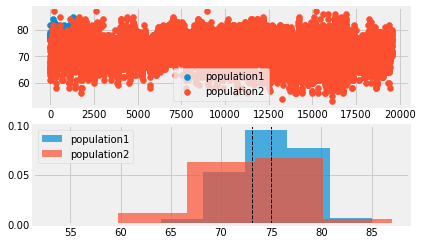

In [120]:
population1, population2 = gendata()

In [ ]:
#this is a paired t test, from the temperature population we are checking mean temperature for jun month and dec month 
in Hawai .
#if i am comparing temperature for a month from Hawai and Srilanka, two different countries then it is a unpaired t test.
#mean value of temperature in jun month is 74.9 F
#mean value of temperature in dec month is 73 F
#from the mean value it is clearly understood jun month is mildly hotter than dec .. but not a huge difference.
#my null hypothesis is there is no difference between the temperature in jun month and december month.
#Alternative hypothesis is jun month has  slightly higher temperature than dec month.
#p value is smaller 1.3 e-94. p value is smaller so i reject the null hypothesis
#I can accept alternative hypothesis jun month has slightly higher temperature than dec month